# ASURANCE PREDICTION WITH LINEAR REGRESSION

Bussines Problem : Perusahaan asuransi ingin memprediksi biaya medis lapangan 
Dataset : Medical Cost Personal Dataset (kagle) - 1338 record

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
print('library load')

library load


# DARA LOADING & EDA

In [4]:
df = pd.read_csv('data/insurance.csv')
print("shape :", df.shape)
df.head()

shape : (330, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


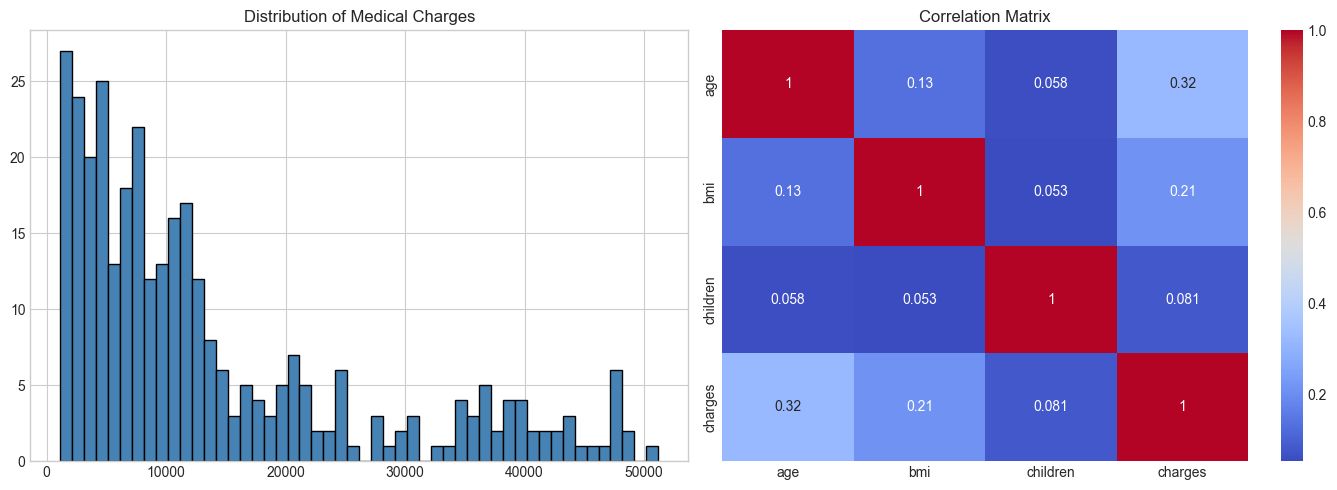

In [5]:
# Target distribution & correlation
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].hist(df['charges'], bins=50, color='steelblue', edgecolor='black')
axes[0].set_title('Distribution of Medical Charges')
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Matrix')
plt.tight_layout()
plt.show()

# feature engginering


In [27]:
# ecnode categorical variables
df_enc = df.copy()
df_enc['sex'] = df_enc['sex'].map({'male': 1, 'female': 0})
df_enc['smoker'] = df_enc['smoker'].map({'yes': 1, 'no' : 0})
df_enc = pd.concat([df_enc.drop('region', axis=1),
                    pd.get_dummies(df_enc['region'], prefix='region', drop_first=True)], axis=1)
X = df_enc.drop('charges', axis=1).values
y = df_enc['charges'].values
feature_name = df_enc.drop('charges', axis=1).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Train : {X_train.shape[0]}, Test : {X_test.shape[0]} samples")

Train : 264, Test : 66 samples


# optimization algorithm from scartch

In [28]:
class NormalEquation:
    def __init__(self): self.theta = None
    
    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        self.theta = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y
        return self
    
    def predict(self, X):
        return np.c_[np.ones((X.shape[0], 1)), X] @ self.theta
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return 1 - np.sum((y-y_pred)**2) / np.sum((y-np.mean(y))**2)

model_ne = NormalEquation().fit(X_train_scaled, y_train)
print(f"Normal Equation - Test R²: {model_ne.score(X_test_scaled, y_test):.4f}")

Normal Equation - Test R²: 0.7090


In [37]:
class BGD:
    def __init__(self, lr=0.01, n_iter=1000):
        self.lr, self.n_iter = lr, n_iter
        self.theta, self.cost_history = None, []
    
    def fit(self, X, y):
        m, n = X.shape
        X_b = np.c_[np.ones((m, 1)), X]
        self.theta = np.random.randn(n + 1) * 0.01

        for _ in range(self.n_iter):
            grad = (1/m) * X_b.T @ (X_b @ self.theta - y)
            self.theta -= self.lr * grad
            self.cost_history.append((1/(2*m)) * np.sum((X_b @ self.theta - y)** 2))
        return self
    
    def predict(self , X): return np.c_[np.ones((X.shape[0], 1)), X] @ self.theta
    def score(self, X, y): return 1 - np.sum((y-self.predict(X))**2 ) / np.sum((y-np.mean(y))** 2)

model_bgd = BGD(lr=0.1, n_iter=500).fit(X_train_scaled, y_train)
print(f"BATCH GD - test R2 : {model_bgd.score(X_test_scaled, y_test):.4f}")

BATCH GD - test R2 : 0.7090


In [40]:
class SGD:
    def __init__(self, lr=0.01, n_epochs=50):
        self.lr, self.n_epochs = lr, n_epochs
        self.theta, self.cost_history = None, []

    def fit(self, X, y):
        m, n = X.shape
        X_b = np.c_[np.ones((m,1)), X]
        self.theta = np.random.randn(n+ 1 ) * 0.01

        for epoch in range(self.n_epochs):
            indices = np.random.permutation(m)
            for i in indices:
                xi, yi = X_b[i:i+1], y[i:i+1]
                grad = xi.T.flatten() * ( xi @ self.theta - yi)
                self.theta -= self.lr * grad
            self.cost_history.append((1/(2*m)) * np.sum((X_b @ self.theta - y )** 2))
            return self
    def predict(self, X): return np.c_[np.ones((X.shape[0],1)),X] @ self.theta
    def score(self,X,y): return 1 - np.sum((y-self.predict(X))**2) / np.sum((y-np.mean(y))**2)

model_sgd = SGD(lr=0.01, n_epochs=50).fit(X_train_scaled, y_train)
print(f"SGD - TEST R2 : {model_sgd.score(X_test_scaled, y_test):.4f}")

SGD - TEST R2 : 0.6778


In [ ]:
class MiniBatchGD:
    def __init__(self, lr=0.01, n_epoch=100, batch_sze=32):
        pass